epoch: 0, iter: 0, loss is: 2.590484619140625
epoch: 1, iter: 0, loss is: 0.06353584676980972
epoch: 2, iter: 0, loss is: 0.046668294817209244
epoch: 3, iter: 0, loss is: 0.03371404856443405
epoch: 4, iter: 0, loss is: 0.04183248430490494
epoch: 5, iter: 0, loss is: 0.048998575657606125
epoch: 6, iter: 0, loss is: 0.05375518649816513
epoch: 7, iter: 0, loss is: 0.03209070861339569
epoch: 8, iter: 0, loss is: 0.038903094828128815
epoch: 9, iter: 0, loss is: 0.04913901910185814
epoch: 10, iter: 0, loss is: 0.04445872828364372
epoch: 11, iter: 0, loss is: 0.03459512069821358
epoch: 12, iter: 0, loss is: 0.03930223733186722
epoch: 13, iter: 0, loss is: 0.028816385194659233
epoch: 14, iter: 0, loss is: 0.04804135486483574
epoch: 15, iter: 0, loss is: 0.03550158813595772
epoch: 16, iter: 0, loss is: 0.03549426794052124
epoch: 17, iter: 0, loss is: 0.04055013135075569
epoch: 18, iter: 0, loss is: 0.04307300224900246
epoch: 19, iter: 0, loss is: 0.04423375427722931
epoch: 20, iter: 0, loss is:

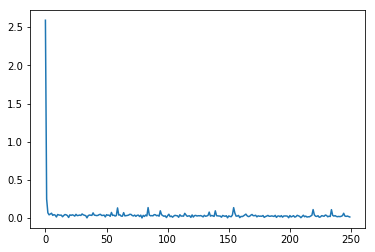

模型保存成功，模型参数保存在LR_model.pdparams中
The test loss is: 0.01243528537452221
Inference result is 16.81325912475586, the corresponding label is 19.524263381958008, the loss is 0.0036294071469455957


In [35]:
import random
import paddle
import numpy as np
from paddle.nn import Linear
import matplotlib.pyplot as plt
import paddle.nn.functional as F


def load_data():
    # 从文件导入数据
    datafile = './data/housing.data'
    data = np.fromfile(datafile, sep=' ', dtype=np.float32)

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', \
                      'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

class Regressor(paddle.nn.Layer):

    def __init__(self):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__()
        
        # 定义两层全连接层
        self.fc1 = Linear(in_features=13, out_features=10)  # 输入维度是13，输出维度是10
        self.fc2 = Linear(in_features=10, out_features=1)   # 输入维度是10，输出维度是1
    
    # 网络的前向计算
    def forward(self, inputs):
        x = F.sigmoid(self.fc1(inputs))
        x = self.fc2(x)
        return x

def train(EPOCH_NUM,BATCH_SIZE):
    # 定义外层循环
    losses = []
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]) # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]) # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图tensor形式
            house_features = paddle.to_tensor(x)
            prices = paddle.to_tensor(y)
            
            # 前向计算
            predicts = model(house_features)
            
            # 计算损失
            loss = F.square_error_cost(predicts, label=prices)
            avg_loss = paddle.mean(loss)
            losses.append(np.squeeze(avg_loss.numpy()))
            if iter_id%20==0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, np.squeeze(avg_loss.numpy())))
            
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.step()
            # 清除梯度
            opt.clear_grad()
    return losses
    
def testing():
    x = np.array(test_data[:, :-1]) # 获得当前批次训练数据
    y = np.array(test_data[:, -1:]) # 获得当前批次训练标签（真实房价）
    # 将numpy数据转为飞桨动态图tensor形式
    house_features = paddle.to_tensor(x)
    prices = paddle.to_tensor(y)
    
    # 前向计算
    predicts = model(house_features)
    
    # 计算损失
    loss = F.square_error_cost(predicts, label=prices)
    avg_loss = paddle.mean(loss)
    print("The test loss is: {}".format(np.squeeze(avg_loss.numpy())))


def load_one_example():
    # 从上边已加载的测试集中，随机选择一条作为测试数据
    # idx = np.random.randint(0, test_data.shape[0])
    idx = -10
    one_data, label = test_data[idx, :-1], test_data[idx, -1]
    # 修改该条数据shape为[1,13]
    one_data =  one_data.reshape([1,-1])

    return one_data, label


def eval():

    # 参数为保存模型参数的文件地址
    model_dict = paddle.load('LR_model.pdparams')
    model.load_dict(model_dict)
    model.eval()

    # 参数为数据集的文件地址
    one_data, label = load_one_example()
    # 将数据转为动态图的variable格式 
    one_data = paddle.to_tensor(one_data)
    label = paddle.to_tensor(label)
    
    predict = model(one_data)
    loss = F.square_error_cost(predict, label=label)
    avg_loss = paddle.mean(loss)

    # 对结果做反归一化处理
    predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
    predict = np.squeeze(predict)
    # 对label数据做反归一化处理
    label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]
    label = np.squeeze(label.numpy())

    print("Inference result is {}, the corresponding label is {}, the loss is {}".format(predict.numpy(), label,np.squeeze(avg_loss.numpy()))) 


if __name__ == '__main__':

    # 声明定义好的线性回归模型
    model = Regressor()
    # 开启模型训练模式
    model.train()
    # 加载数据
    training_data, test_data = load_data()
    # 定义优化算法，使用随机梯度下降SGD
    # 学习率设置为0.1
    opt = paddle.optimizer.SGD(learning_rate=0.1, parameters=model.parameters())


    EPOCH_NUM = 50   # 设置外层循环次数
    BATCH_SIZE = 100  # 设置batch大小

    losses = train(EPOCH_NUM, BATCH_SIZE)
    
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.show()

    # 保存模型参数，文件名为LR_model.pdparams
    paddle.save(model.state_dict(), 'LR_model.pdparams')
    print("模型保存成功，模型参数保存在LR_model.pdparams中")

    testing()             # 测试集上的损失
    eval()                # 某一条数据的验证

Epoch   0 / iter   0, loss = 0.6326
Epoch   0 / iter   1, loss = 1.1028
Epoch   0 / iter   2, loss = 0.1070
Epoch   0 / iter   3, loss = 0.0241
Epoch   0 / iter   4, loss = 0.0169
Epoch   1 / iter   0, loss = 0.0313
Epoch   1 / iter   1, loss = 0.0318
Epoch   1 / iter   2, loss = 0.0319
Epoch   1 / iter   3, loss = 0.0218
Epoch   1 / iter   4, loss = 0.0192
Epoch   2 / iter   0, loss = 0.0212
Epoch   2 / iter   1, loss = 0.0228
Epoch   2 / iter   2, loss = 0.0186
Epoch   2 / iter   3, loss = 0.0220
Epoch   2 / iter   4, loss = 0.0086
Epoch   3 / iter   0, loss = 0.0250
Epoch   3 / iter   1, loss = 0.0152
Epoch   3 / iter   2, loss = 0.0180
Epoch   3 / iter   3, loss = 0.0124
Epoch   3 / iter   4, loss = 0.0249
Epoch   4 / iter   0, loss = 0.0150
Epoch   4 / iter   1, loss = 0.0134
Epoch   4 / iter   2, loss = 0.0123
Epoch   4 / iter   3, loss = 0.0230
Epoch   4 / iter   4, loss = 0.0071
Epoch   5 / iter   0, loss = 0.0157
Epoch   5 / iter   1, loss = 0.0134
Epoch   5 / iter   2, loss =

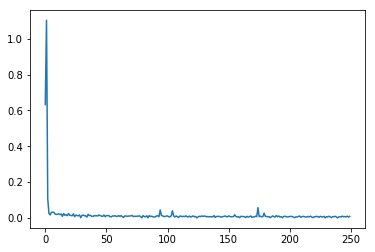

In [36]:
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    # sigmoid激活函数
    return 1/(1+np.exp(-x))

def dsigmoid(x):
    # sigmoid激活函数的导数
    return x*(1-x)

def load_data():
    # 从文件导入数据
    datafile = './data/housing.data'
    data = np.fromfile(datafile, sep=' ')

    # 每条数据包括14项，其中前面13项是影响因素，第14项是相应的房屋价格中位数
    feature_names = [ 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',                       'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV' ]
    feature_num = len(feature_names)

    # 将原始数据进行Reshape，变成[N, 14]这样的形状
    data = data.reshape([data.shape[0] // feature_num, feature_num])

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算训练集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0),                                  training_data.sum(axis=0) / training_data.shape[0]

    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        #print(maximums[i], minimums[i], avgs[i])
        data[:, i] = (data[:, i] - minimums[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data


class Network(object):
    def __init__(self, num_of_weights,hidden_sum):
        # 随机产生w的初始值
        # 为了保持程序每次运行结果的一致性，此处设置固定的随机数种子
        np.random.seed(0)
        self.w_1 = np.random.randn(num_of_weights, hidden_sum)  # 第一个全连接层的网络参数
        self.b_1 = np.zeros(hidden_sum)
        self.w_2 = np.random.randn(hidden_sum,1)                # 第二个全连接层的网络参数
        self.b_2 = 0.
        
    def forward(self, x):
        # 前向传播
        z = np.dot(x, self.w_1) + self.b_1     # 全连接层
        z = sigmoid(z)                         # sigmoid激活层
        z = np.dot(z, self.w_2) + self.b_2     # 全连接层
        return z
    
    def loss(self, z, y):
        # 均方差损失函数计算
        error = z - y
        cost = error * error
        cost = np.mean(cost) / 2
        return cost
    
    def gradient(self, x, y):
        # 梯度计算
        o_1 = sigmoid(np.dot(x, self.w_1) + self.b_1)    # 第一个全连接层的输出
        z = self.forward(x)                              # 第一个全连接层的输出

        gradient_w_1 = x.T.dot((z-y).dot(self.w_2.T) * dsigmoid(o_1))           # 第一个全连接层参数的梯度
        gradient_b_1 = np.mean((z-y).dot(self.w_2.T) * dsigmoid(o_1), axis=0) 

        # gradient_w_2 = o_1.T.dot((z-y))
        gradient_w_2 = np.mean((z-y)*o_1,axis=0)                                # 第二个全连接层参数的梯度
        gradient_w_2 = gradient_w_2[:,np.newaxis]
        gradient_b_2 = np.mean((z-y))
        return gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2
    
    def update(self, gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta = 0.01):
        # 梯度下降，网络参数更新
        self.w_1 = self.w_1 - eta * gradient_w_1
        self.b_1 = self.b_1 - eta * gradient_b_1
        self.w_2 = self.w_2 - eta * gradient_w_2
        self.b_2 = self.b_2 - eta * gradient_b_2
            
                
    def train(self, training_data, num_epochs, batch_size=10, eta=0.01):
        n = len(training_data)
        losses = []
        for epoch_id in range(num_epochs):
            # 在每轮迭代开始之前，将训练数据的顺序随机打乱
            # 然后再按每次取batch_size条数据的方式取出
            np.random.shuffle(training_data)
            # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
            mini_batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for iter_id, mini_batch in enumerate(mini_batches):
                #print(self.w.shape)
                #print(self.b)
                x = mini_batch[:, :-1]   # 特征
                y = mini_batch[:, -1:]   # 标签
                a = self.forward(x)      # 网络输出
                loss = self.loss(a, y)   # 网络损失
                gradient_w_1, gradient_b_1, gradient_w_2, gradient_b_2 = self.gradient(x, y)  # 参数梯度
                self.update(gradient_w_1, gradient_w_2, gradient_b_1, gradient_b_2, eta)      # 更新参数
                losses.append(loss)                                                           # 记录损失
                print('Epoch {:3d} / iter {:3d}, loss = {:.4f}'.
                                 format(epoch_id, iter_id, loss))
        
        return losses

    def test(self,test_data):
        x = test_data[:, :-1]   # 特征
        y = test_data[:, -1:]   # 标签
        a = self.forward(x)      # 网络输出
        loss = self.loss(a, y)   # 网络损失
        print('The testing loss = {:.4f}'.format(loss))

    def eval(self,test_data):
        idx = -12
        # idx = np.random.randint(0, test_data.shape[0])
        one_data, label = test_data[idx, :-1], test_data[idx, -1]
        one_data =  one_data.reshape([1,-1])      # 修改该条数据shape为[1,13]
        
        
        predict = self.forward(one_data)
        predict = np.squeeze(predict)   # 去除冗余维度
        loss = self.loss(predict, label)

        # 对结果做反归一化处理
        predict = predict * (max_values[-1] - min_values[-1]) + avg_values[-1]
        # 对label数据做反归一化处理
        label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

        print("Inference result is {}, the corresponding label is {}, the loss is {}".format(predict, label, loss))




if __name__ == '__main__':
    # 获取数据
    train_data, test_data = load_data()

    # 创建网络
    net = Network(13,10)   # 隐层节点数10

    # 启动训练
    # mini_batch,batch_size=100,learning_rate=0.1
    losses = net.train(train_data, num_epochs=50, batch_size=100, eta=0.1)  
    net.test(test_data)  # 测试集的效果
    net.eval(test_data)  # 单条数据效果验证

    # 画出损失函数的变化趋势
    plot_x = np.arange(len(losses))
    plot_y = np.array(losses)
    plt.plot(plot_x, plot_y)
    plt.show()